In [1]:
from anova import global_hpi, local_hpi
import numpy as np
import matplotlib.pyplot as plt
import os


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
plt.rcParams['mathtext.fontset'] = 'stix'  # The setting of math font

os.makedirs("figs/", exist_ok=True)

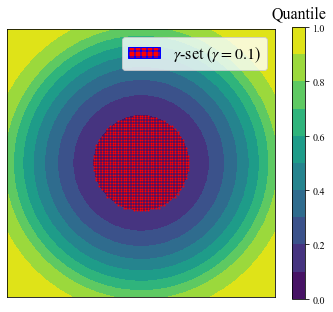

In [2]:
from scipy.stats import rankdata

TICK_PARAMS = dict(
    labelleft=False,
    labelbottom=False,
    left=False,
    bottom=False,
)

fig, ax = plt.subplots(
    figsize=(6, 5),
)
ax.tick_params(**TICK_PARAMS)

LB, UB, n_grids, CENTER = -5, 5, 100, 0


def func(X, Y):
    return (X - CENTER) ** 2 + (Y - CENTER) ** 2


cm = plt.get_cmap()
dx, dy = np.linspace(LB, UB, n_grids), np.linspace(LB, UB, n_grids)
X, Y = np.meshgrid(dx, dy)
Z = func(X, Y)
level = np.linspace(0, 1, 11)
quantile = (rankdata(Z) / Z.size).reshape(Z.shape)

gamma_set_mask = (quantile < 0.1)
cb = ax.contourf(X, Y, quantile, level, cmap=cm)
cbar = fig.colorbar(cb)
cbar.ax.set_title("Quantile", y=1.01, fontsize=16)
ax.scatter(
    X[gamma_set_mask].flatten(),
    Y[gamma_set_mask].flatten(),
    color="red",
    s=1,
)

zeros = np.zeros(2)
ax.fill_between(
    zeros,
    zeros,
    zeros,
    color="red",
    label="$\gamma$-set ($\gamma = 0.1$)",
    hatch=r"++",
    facecolor="red",
    edgecolor="blue",
)

ax.set_aspect('equal', 'box')
ax.set_xlim(LB, UB)
ax.set_ylim(LB, UB)
ax.legend(fontsize=16)

plt.savefig("figs/gamma-set-conceptual.pdf", bbox_inches="tight")

In [3]:
%reset

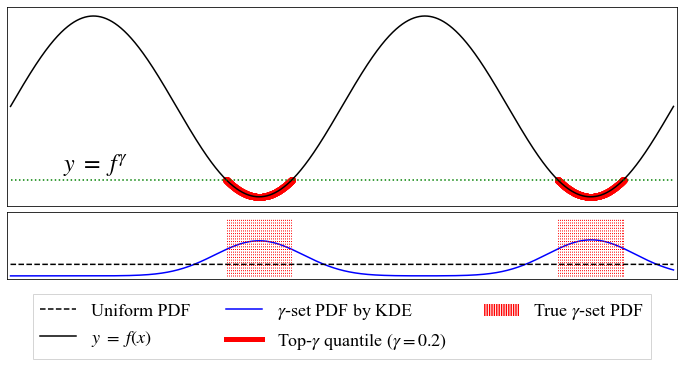

In [5]:
from anova import global_hpi, local_hpi
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata

from parzen_estimator import NumericalParzenEstimator, NumericalUniform


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
plt.rcParams['mathtext.fontset'] = 'stix'  # The setting of math font

TICK_PARAMS = dict(
    labelleft=False,
    labelbottom=False,
    left=False,
    bottom=False,
)
_, axes = plt.subplots(
    nrows=2,
    figsize=(12, 5),
    sharex=True,
    gridspec_kw=dict(
        height_ratios=(3, 1),
        hspace=0.05
    )
)
for i in range(2):
    axes[i].tick_params(**TICK_PARAMS)

LB, UB, n_grids = -2 * np.pi, 2 * np.pi, 10000

def func(x):
    return np.sin(x)


zeros = np.zeros(2)
lines = []
X = np.linspace(LB, UB, n_grids)
Y = np.sin(X)
gamma = 0.2
quantile = rankdata(Y) / Y.size

ax = axes[0]
labels = [
    "$y ~=~ f(x)$",
    "Top-$\gamma$ quantile ($\gamma = 0.2$)",
    "$\gamma$-set PDF by KDE",
    "Uniform PDF",
    "True $\gamma$-set PDF",
]
line, = ax.plot(X, Y, color="black", label=labels[0])
lines.append(line)
ax.scatter(
    X[quantile < gamma],
    Y[quantile < gamma],
    color="red",
    s=30,
)
line, = ax.plot(zeros - 1000, zeros, color="red", label=labels[1], lw=5)
lines.append(line)

f_gamma = Y[quantile < gamma].max()
ax.text(LB + 1, f_gamma + 0.1, "$y ~=~ f^\gamma$", fontsize=24)
ax.hlines(f_gamma, LB, UB, linestyle="dotted", color="green")

ax = axes[1]
pe = NumericalParzenEstimator(samples=X[quantile < gamma], lb=LB, ub=UB)
line, = ax.plot(X, pe(X), color="blue", label=labels[2])
lines.append(line)

u = NumericalUniform(lb=LB, ub=UB)
line, = ax.plot(X, u(X), color="black", linestyle="dashed", label=labels[3])
lines.append(line)

markevery = 30

uniform_val = 1 / (gamma * (UB - LB))
ax.vlines(
    X[quantile < gamma][markevery//2::markevery],
    0,
    uniform_val,
    color="red",
    lw=1,
    linestyle="dotted"
)
line = ax.fill_between(zeros - 1000, zeros, zeros, hatch=r"|||||", facecolor="red", edgecolor="white")
lines.append(line)
ax.set_ylim(top=uniform_val * 1.1)


def swap(i, j):
    lines[i], lines[j] = lines[j], lines[i]
    labels[i], labels[j] = labels[j], labels[i]


swap(0, 1)
swap(0, 3)

ax.set_xlim(LB * 1.01, UB * 1.01)
ax.legend(
    handles=lines,
    labels=labels,
    loc="upper center",
    ncols=(len(labels) + 1) // 2,
    fontsize=18,
    bbox_to_anchor=(0.5, -0.1),  # ここは調整が必要です
    fancybox=False,
    shadow=False,
)
plt.savefig("figs/empirical-gamma-set-pdf-conceptual.pdf", bbox_inches="tight")